# 따라해보기 2번째
[출처](https://www.kaggle.com/gordotron85/future-sales-xgboost-top-3)

In [24]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import time
import gc
import pickle
# 버전 1.2로 업그레이드하면 gpu 사용 가능할듯?
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
sns.set(style="darkgrid")

In [22]:
items=pd.read_csv("data/items.csv")
shops=pd.read_csv("data/shops.csv")
cats=pd.read_csv("data/item_categories.csv")
train=pd.read_csv("data/sales_train.csv")
test=pd.read_csv("data/test.csv")

## Remove outliers

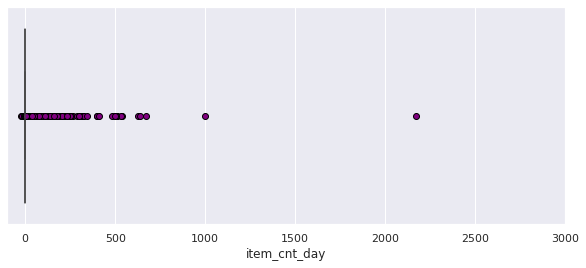

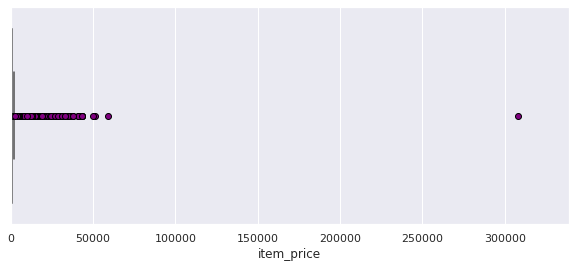

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

여기서는 300,000 미만 1000 미만으로 기준잡음

In [4]:
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]

0 미만 값을 지워버림

In [5]:
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

## cleaning shop data

가게 이름 중복

In [6]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

가게 이름에 도시, 카테고리

In [7]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

해당 카테고리에 가게 5개 이상 있어야 남기고 아니라면 기타로 편입

In [8]:
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )

In [9]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

## Cleaning Item Category Data

In [10]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"

In [11]:
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")

In [12]:
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]

## Cleaning Item Data

In [13]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

clean item names

In [14]:
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


clean item type

In [15]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [16]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

In [17]:
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


### Preprocessing
Create a matrix df with every combination of month, shop and item in order of increasing month. Item_cnt_day is summed into an item_cnt_month.

In [18]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

11.241028547286987

In [19]:
# add revenue to train df
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [20]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
time.time() - ts

2.7000348567962646

Create a test set for month 34.

In [21]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

Concatenate train and test sets.

In [22]:
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.04097270965576172

Add shop, items and categories data onto matrix df.

In [23]:
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

2.467362403869629

### Feature Engineering

In [24]:
# Add lag features to matrix df.
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

Add item_cnt_month lag features

In [25]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


11.548080921173096

Add the previous month's average item_cnt.

In [26]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


6.0499653816223145

Add lag values of item_cnt_month for month / item_id.

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


14.55087161064148

Add lag values for item_cnt_month for every month / shop combination.

In [28]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_avg_item_cnt


15.218366861343384

Add lag values for item_cnt_month for month/shop/item.

In [29]:
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


date_shop_item_avg_item_cnt


20.041032552719116

Add lag values for item_cnt_month for month/shop/item subtype.

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_subtype_avg_item_cnt


7.732778549194336

Add lag values for item_cnt_month for month/city.

In [31]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


7.476494550704956

Add lag values for item_cnt_month for month/city/item.

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


11.939242124557495

- Add average item price on to matix df.
- Add lag values of item price per month.
- Add delta price values - how current month average pirce relates to global average.

In [33]:
ts = time.time()
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


239.7897927761078

- Add total shop revenue per month to matix df.
- Add lag values of revenue per month.
- Add delta revenue values - how current month revenue relates to global average.

In [34]:
ts = time.time()
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts


delta_revenue


8.324764966964722

Add month and number of days in each month to matrix df.

In [35]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

Add the month of each shop and item first sale.

In [36]:
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

1.2436347007751465

Delete first three months from matrix. They don't have lag values.

In [37]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

0.5895810127258301

In [38]:
matrix.head().T

,1497465,1497466,1497467,1497468,1497469
date_block_num,4.000000,4.000000,4.0,4.000000,4.000000
shop_id,2.000000,2.000000,2.0,2.000000,2.000000
item_id,27.000000,28.000000,29.0,30.000000,31.000000
item_cnt_month,0.000000,0.000000,0.0,0.000000,0.000000
shop_category,4.000000,4.000000,4.0,4.000000,4.000000
shop_city,0.000000,0.000000,0.0,0.000000,0.000000
item_category_id,19.000000,30.000000,23.0,40.000000,37.000000
name2,76.000000,107.000000,123.0,4.000000,4.000000
name3,42.000000,42.000000,42.0,42.000000,562.000000
subtype_code,10.000000,55.000000,16.0,4.000000,1.000000


In [3]:
reg_2_dir = './practice_reg_2_results/'

In [ ]:
matrix.to_pickle(reg_2_dir+'data.pkl')

# Modeling

In [5]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [42]:
data = matrix.copy()
del matrix
gc.collect()

12

In [6]:
data = pd.read_pickle(reg_2_dir+'data.pkl')
data[data["date_block_num"]==34].shape

(214200, 33)

Use month 34 as validation for training.

In [7]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [8]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [9]:
del data
gc.collect();

In [47]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[11:42:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.17824	validation_1-rmse:1.12031
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.12705	validation_1-rmse:1.08058
[2]	validation_0-rmse:1.08285	validation_1-rmse:1.05086
[3]	validation_0-rmse:1.04711	validation_1-rmse:1.02283
[4]	validation_0-rmse:1.01522	validation_1-rmse:1.00085
[5]	validation_0-rmse:0.98763	validation_1-rmse:0.98171
[6]	validation_0-rmse:0.96327	validation_1-rmse:0.96864
[7]	validation_0-rmse:0.94401	validation_1-rmse:0.95857
[8]	validation_0-rmse:0.92500	validation_1-rmse:0.94715
[9]	validation_0-rmse:0.91011	validation_1-rmse:0.93922
[10]	

433.5217032432556

In [48]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})

messages = 'earlystopping20'
submission.to_csv(reg_2_dir+'XGBRegressor_{}_submission.csv'.format(messages), index=False)

In [49]:
messages = 'earlystopping20'
pickle.dump(Y_pred, open(reg_2_dir+'xgb_pred_{}.pickle'.format(messages), 'wb'))
pickle.dump(Y_test, open(reg_2_dir+'xgb_test_{}.pickle'.format(messages), 'wb'))

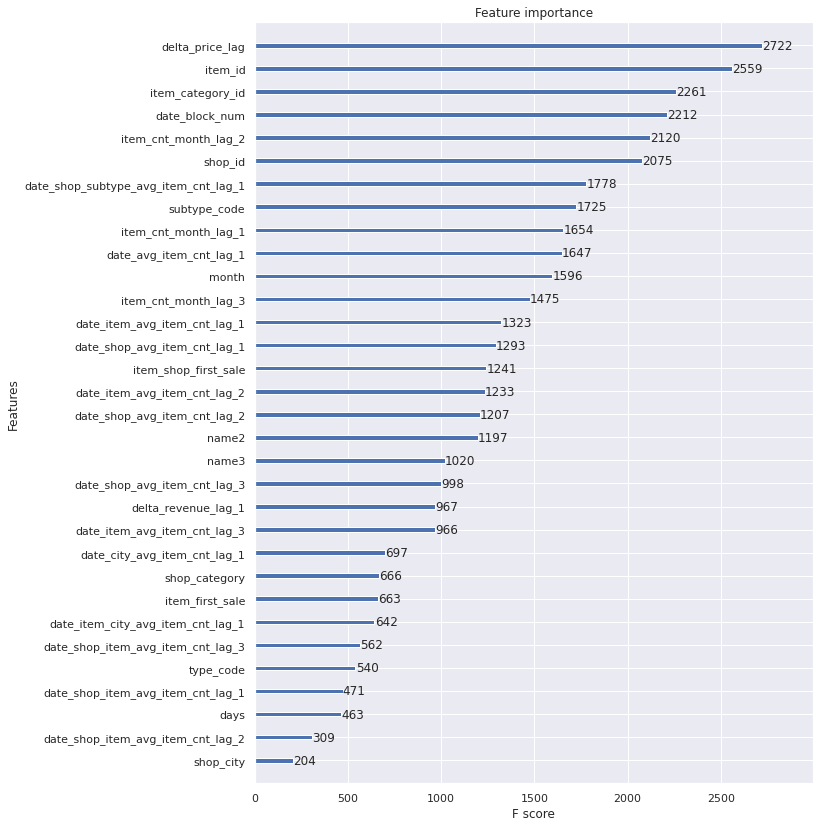

In [50]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

## XGB 제출결과
0.89677 (public)

# 비교 및 시도
'practice_reg' 에서 했던 것과 전처리 과정이 굉장히 비슷하지만, 결과가 다르게 나온다고 한다 (커널 작성자의 결과에 따르면)    

## 그나마 차이점을 찾자면,    

- 하이퍼 파라미터 차이
    - max_depth 값이 8이 아닌 10
    - min_child_weight 300 이 아닌 0.5
    - eat 값 0.3 아닌 0.1
- 전처리 차이
    - Outlier 처리
        - 마이너스 값 median 처리 아닌 제거
        - 판매량 1001개 미만 아닌 1000개 미만 (1000개짜리를 제거함)
    - ...
    
## 그래서
이 데이터를 가지고 LGBM, XGM 앙상블을 해봐야겠다.

# Ensemble XGB, LGBM


## 일단 LGBM

In [51]:
from lightgbm import LGBMRegressor
ts = time.time()

model = LGBMRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[1]	training's rmse: 1.16715	training's l2: 1.36224	valid_1's rmse: 1.0983	valid_1's l2: 1.20626
Training until validation scores don't improve for 20 rounds
[2]	training's rmse: 1.12501	training's l2: 1.26564	valid_1's rmse: 1.06512	valid_1's l2: 1.13447
[3]	training's rmse: 1.0895	training's l2: 1.18702	valid_1's rmse: 1.04034	valid_1's l2: 1.08231
[4]	training's rmse: 1.05941	training's l2: 1.12235	valid_1's rmse: 1.01982	valid_1's l2: 1.04003
[5]	training's rmse: 1.03447	training's l2: 1.07013	valid_1's rmse: 1.00309	valid_1's l2: 1.0062
[6]	training's rmse: 1.01252	training's l2: 1.0252	valid_1's rmse: 0.987967	valid_1's l2: 0.976079
[7]	training's rmse: 0.993972	training's l2: 0.98798	valid_1's rmse: 0.975363	valid_1's l2: 0.951334
[8]	training's rmse: 0.978658	training's l2: 0.957772	valid_1's rmse: 0.965643	valid_1's l2: 0.932467
[9]	training's rmse: 0.964903	training's l2: 0.931037	valid_1's rmse: 0.958896	valid_1's l2: 0.919481
[10]	training's rmse: 0.953405	training's l2: 0.

[81]	training's rmse: 0.846107	training's l2: 0.715897	valid_1's rmse: 0.910158	valid_1's l2: 0.828387
[82]	training's rmse: 0.845707	training's l2: 0.71522	valid_1's rmse: 0.910036	valid_1's l2: 0.828165
[83]	training's rmse: 0.845371	training's l2: 0.714652	valid_1's rmse: 0.909912	valid_1's l2: 0.827941
[84]	training's rmse: 0.845064	training's l2: 0.714132	valid_1's rmse: 0.909905	valid_1's l2: 0.827927
[85]	training's rmse: 0.84479	training's l2: 0.71367	valid_1's rmse: 0.909676	valid_1's l2: 0.827511
[86]	training's rmse: 0.844494	training's l2: 0.71317	valid_1's rmse: 0.909634	valid_1's l2: 0.827434
[87]	training's rmse: 0.844261	training's l2: 0.712777	valid_1's rmse: 0.909582	valid_1's l2: 0.827339
[88]	training's rmse: 0.844013	training's l2: 0.712358	valid_1's rmse: 0.909425	valid_1's l2: 0.827054
[89]	training's rmse: 0.843066	training's l2: 0.71076	valid_1's rmse: 0.908971	valid_1's l2: 0.826228
[90]	training's rmse: 0.842783	training's l2: 0.710284	valid_1's rmse: 0.90895

[161]	training's rmse: 0.824674	training's l2: 0.680088	valid_1's rmse: 0.901353	valid_1's l2: 0.812437
[162]	training's rmse: 0.824384	training's l2: 0.67961	valid_1's rmse: 0.901228	valid_1's l2: 0.812212
[163]	training's rmse: 0.824256	training's l2: 0.679398	valid_1's rmse: 0.901208	valid_1's l2: 0.812177
[164]	training's rmse: 0.823925	training's l2: 0.678852	valid_1's rmse: 0.900968	valid_1's l2: 0.811743
[165]	training's rmse: 0.823772	training's l2: 0.6786	valid_1's rmse: 0.900908	valid_1's l2: 0.811635
[166]	training's rmse: 0.823504	training's l2: 0.678158	valid_1's rmse: 0.90072	valid_1's l2: 0.811296
[167]	training's rmse: 0.823367	training's l2: 0.677933	valid_1's rmse: 0.900686	valid_1's l2: 0.811236
[168]	training's rmse: 0.822788	training's l2: 0.67698	valid_1's rmse: 0.900684	valid_1's l2: 0.811231
[169]	training's rmse: 0.822682	training's l2: 0.676806	valid_1's rmse: 0.900679	valid_1's l2: 0.811223
[170]	training's rmse: 0.82242	training's l2: 0.676375	valid_1's rmse

53.14027690887451

In [52]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
messages = 'earlystopping20'
# reg_2_dir = './practice_reg_2_results/'
submission.to_csv(reg_2_dir+'LGBMRegressor_{}_submission.csv'.format(messages), index=False)

In [53]:
pickle.dump(Y_pred, open(reg_2_dir+'lgbm_pred_{}.pickle'.format(messages), 'wb'))
pickle.dump(Y_test, open(reg_2_dir+'lgbm_test_{}.pickle'.format(messages), 'wb'))

## Ensemble

In [20]:
def submission_for_ensemble(names,messages,Y_test):
    submission = pd.DataFrame({
        "ID": test.index, 
        "item_cnt_month": Y_test
    })
    submission.to_csv(reg_2_dir+'ensemble_reg_2_{0}_{1}_submission.csv'.format(names,messages), index=False)

### 평균

In [19]:
def AveragingBlending(preds):     
    
    predictions = np.column_stack([
       pred for pred in preds
    ])
    
    return np.mean(predictions, axis=1)

In [56]:
messages = 'earlystopping20'
# reg_2_dir = './practice_reg_2_results/'
xgb_pred = pd.read_pickle(reg_2_dir+'xgb_pred_{}.pickle'.format(messages))
xgb_test = pd.read_pickle(reg_2_dir+'xgb_test_{}.pickle'.format(messages))
lgbm_pred = pd.read_pickle(reg_2_dir+'lgbm_pred_{}.pickle'.format(messages))
lgbm_test = pd.read_pickle(reg_2_dir+'lgbm_test_{}.pickle'.format(messages))

preds = [xgb_pred,lgbm_pred]
tests = [xgb_test,lgbm_test]
Y_pred = AveragingBlending(preds).clip(0, 20)
Y_test = AveragingBlending(tests).clip(0, 20)
print(Y_pred)
print(Y_test)
messages = 'average_earlystopping20'
submission_for_ensemble('xgb,lgbm',messages,Y_test)

[0.03220883 0.10164049 0.20591469 ... 0.18719302 0.02350964 0.11172622]
[0.5604175  0.43517462 0.94139383 ... 0.05979854 0.04047892 0.05774042]


### xgb, lgbm 평균 ensemble 제출결과
0.89305 (public)

# 다른 모델 해보자

In [10]:
import catboost
from catboost import Pool
from catboost import CatBoostRegressor

In [11]:
catboost.__version__

'0.11.1'

In [14]:
ts = time.time()

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4,
    learning_rate=0.01,
#     task_type="GPU"
)

catboost_model.fit(
    X_train, Y_train,
    eval_set=(X_valid, Y_valid),
    verbose=True,
    early_stopping_rounds = 20
)
cat_pred = catboost_model.predict(X_valid).clip(0, 20)
cat_test = catboost_model.predict(X_test).clip(0, 20)
time.time() - ts

0:	learn: 1.2474230	test: 1.1627836	best: 1.1627836 (0)	total: 564ms	remaining: 4m 41s
1:	learn: 1.2429451	test: 1.1594822	best: 1.1594822 (1)	total: 1.1s	remaining: 4m 33s
2:	learn: 1.2385407	test: 1.1562402	best: 1.1562402 (2)	total: 1.69s	remaining: 4m 40s
3:	learn: 1.2341964	test: 1.1530627	best: 1.1530627 (3)	total: 2.27s	remaining: 4m 41s
4:	learn: 1.2299324	test: 1.1499593	best: 1.1499593 (4)	total: 2.83s	remaining: 4m 39s
5:	learn: 1.2257256	test: 1.1468963	best: 1.1468963 (5)	total: 3.36s	remaining: 4m 36s
6:	learn: 1.2215882	test: 1.1439049	best: 1.1439049 (6)	total: 3.88s	remaining: 4m 33s
7:	learn: 1.2175180	test: 1.1409513	best: 1.1409513 (7)	total: 4.43s	remaining: 4m 32s
8:	learn: 1.2134975	test: 1.1380488	best: 1.1380488 (8)	total: 4.99s	remaining: 4m 32s
9:	learn: 1.2095440	test: 1.1352002	best: 1.1352002 (9)	total: 5.53s	remaining: 4m 31s
10:	learn: 1.2056575	test: 1.1323875	best: 1.1323875 (10)	total: 6.06s	remaining: 4m 29s
11:	learn: 1.2018273	test: 1.1296850	best:

93:	learn: 1.0220667	test: 1.0088454	best: 1.0088454 (93)	total: 52.4s	remaining: 3m 46s
94:	learn: 1.0209650	test: 1.0081481	best: 1.0081481 (94)	total: 53s	remaining: 3m 45s
95:	learn: 1.0198365	test: 1.0075103	best: 1.0075103 (95)	total: 53.6s	remaining: 3m 45s
96:	learn: 1.0187377	test: 1.0068177	best: 1.0068177 (96)	total: 54.1s	remaining: 3m 44s
97:	learn: 1.0176083	test: 1.0060168	best: 1.0060168 (97)	total: 54.7s	remaining: 3m 44s
98:	learn: 1.0165326	test: 1.0054208	best: 1.0054208 (98)	total: 55.4s	remaining: 3m 44s
99:	learn: 1.0154915	test: 1.0047733	best: 1.0047733 (99)	total: 56s	remaining: 3m 43s
100:	learn: 1.0144804	test: 1.0041529	best: 1.0041529 (100)	total: 56.6s	remaining: 3m 43s
101:	learn: 1.0134867	test: 1.0035584	best: 1.0035584 (101)	total: 57.1s	remaining: 3m 42s
102:	learn: 1.0124745	test: 1.0029931	best: 1.0029931 (102)	total: 57.6s	remaining: 3m 42s
103:	learn: 1.0114864	test: 1.0023723	best: 1.0023723 (103)	total: 58.2s	remaining: 3m 41s
104:	learn: 1.010

183:	learn: 0.9627898	test: 0.9744886	best: 0.9744886 (183)	total: 1m 43s	remaining: 2m 57s
184:	learn: 0.9624281	test: 0.9742669	best: 0.9742669 (184)	total: 1m 43s	remaining: 2m 56s
185:	learn: 0.9620765	test: 0.9740520	best: 0.9740520 (185)	total: 1m 44s	remaining: 2m 55s
186:	learn: 0.9617255	test: 0.9739019	best: 0.9739019 (186)	total: 1m 44s	remaining: 2m 55s
187:	learn: 0.9613883	test: 0.9737687	best: 0.9737687 (187)	total: 1m 45s	remaining: 2m 54s
188:	learn: 0.9610550	test: 0.9735669	best: 0.9735669 (188)	total: 1m 45s	remaining: 2m 54s
189:	learn: 0.9607114	test: 0.9734185	best: 0.9734185 (189)	total: 1m 46s	remaining: 2m 53s
190:	learn: 0.9603831	test: 0.9732378	best: 0.9732378 (190)	total: 1m 47s	remaining: 2m 53s
191:	learn: 0.9600499	test: 0.9730981	best: 0.9730981 (191)	total: 1m 47s	remaining: 2m 52s
192:	learn: 0.9597236	test: 0.9730054	best: 0.9730054 (192)	total: 1m 48s	remaining: 2m 52s
193:	learn: 0.9594031	test: 0.9728122	best: 0.9728122 (193)	total: 1m 48s	remain

273:	learn: 0.9391788	test: 0.9621598	best: 0.9621598 (273)	total: 2m 35s	remaining: 2m 7s
274:	learn: 0.9390344	test: 0.9621122	best: 0.9621122 (274)	total: 2m 35s	remaining: 2m 7s
275:	learn: 0.9388951	test: 0.9620606	best: 0.9620606 (275)	total: 2m 36s	remaining: 2m 6s
276:	learn: 0.9387583	test: 0.9620116	best: 0.9620116 (276)	total: 2m 36s	remaining: 2m 6s
277:	learn: 0.9386087	test: 0.9619663	best: 0.9619663 (277)	total: 2m 37s	remaining: 2m 5s
278:	learn: 0.9384739	test: 0.9619034	best: 0.9619034 (278)	total: 2m 37s	remaining: 2m 5s
279:	learn: 0.9382367	test: 0.9617280	best: 0.9617280 (279)	total: 2m 38s	remaining: 2m 4s
280:	learn: 0.9380093	test: 0.9615882	best: 0.9615882 (280)	total: 2m 39s	remaining: 2m 4s
281:	learn: 0.9377706	test: 0.9613620	best: 0.9613620 (281)	total: 2m 39s	remaining: 2m 3s
282:	learn: 0.9376388	test: 0.9612848	best: 0.9612848 (282)	total: 2m 40s	remaining: 2m 2s
283:	learn: 0.9374288	test: 0.9611025	best: 0.9611025 (283)	total: 2m 40s	remaining: 2m 2s

363:	learn: 0.9272766	test: 0.9553195	best: 0.9553195 (363)	total: 3m 27s	remaining: 1m 17s
364:	learn: 0.9271985	test: 0.9552749	best: 0.9552749 (364)	total: 3m 27s	remaining: 1m 16s
365:	learn: 0.9269569	test: 0.9550193	best: 0.9550193 (365)	total: 3m 28s	remaining: 1m 16s
366:	learn: 0.9268498	test: 0.9549287	best: 0.9549287 (366)	total: 3m 29s	remaining: 1m 15s
367:	learn: 0.9267767	test: 0.9549134	best: 0.9549134 (367)	total: 3m 29s	remaining: 1m 15s
368:	learn: 0.9266630	test: 0.9548044	best: 0.9548044 (368)	total: 3m 30s	remaining: 1m 14s
369:	learn: 0.9265890	test: 0.9547754	best: 0.9547754 (369)	total: 3m 30s	remaining: 1m 14s
370:	learn: 0.9265173	test: 0.9547334	best: 0.9547334 (370)	total: 3m 31s	remaining: 1m 13s
371:	learn: 0.9264435	test: 0.9546732	best: 0.9546732 (371)	total: 3m 31s	remaining: 1m 12s
372:	learn: 0.9263671	test: 0.9546784	best: 0.9546732 (371)	total: 3m 32s	remaining: 1m 12s
373:	learn: 0.9262934	test: 0.9546714	best: 0.9546714 (373)	total: 3m 33s	remain

454:	learn: 0.9197261	test: 0.9506862	best: 0.9506719 (453)	total: 4m 20s	remaining: 25.7s
455:	learn: 0.9196814	test: 0.9506756	best: 0.9506719 (453)	total: 4m 20s	remaining: 25.2s
456:	learn: 0.9196388	test: 0.9506265	best: 0.9506265 (456)	total: 4m 21s	remaining: 24.6s
457:	learn: 0.9196004	test: 0.9506356	best: 0.9506265 (456)	total: 4m 21s	remaining: 24s
458:	learn: 0.9195556	test: 0.9506261	best: 0.9506261 (458)	total: 4m 22s	remaining: 23.4s
459:	learn: 0.9195144	test: 0.9505933	best: 0.9505933 (459)	total: 4m 22s	remaining: 22.9s
460:	learn: 0.9194681	test: 0.9505882	best: 0.9505882 (460)	total: 4m 23s	remaining: 22.3s
461:	learn: 0.9193905	test: 0.9505585	best: 0.9505585 (461)	total: 4m 24s	remaining: 21.7s
462:	learn: 0.9193447	test: 0.9505480	best: 0.9505480 (462)	total: 4m 24s	remaining: 21.1s
463:	learn: 0.9193056	test: 0.9505395	best: 0.9505395 (463)	total: 4m 25s	remaining: 20.6s
464:	learn: 0.9192627	test: 0.9505276	best: 0.9505276 (464)	total: 4m 25s	remaining: 20s
465

311.11573338508606

In [15]:
messages = 'earlystopping20'
pickle.dump(cat_pred, open(reg_2_dir+'cat_pred_{}.pickle'.format(messages), 'wb'))
pickle.dump(cat_test, open(reg_2_dir+'cat_test_{}.pickle'.format(messages), 'wb'))

## catboost 포함해서 ensemble


In [23]:
messages = 'earlystopping20'
# reg_2_dir = './practice_reg_2_results/'
xgb_pred = pd.read_pickle(reg_2_dir+'xgb_pred_{}.pickle'.format(messages))
xgb_test = pd.read_pickle(reg_2_dir+'xgb_test_{}.pickle'.format(messages))
lgbm_pred = pd.read_pickle(reg_2_dir+'lgbm_pred_earlystopping20 .pickle')
# lgbm_pred = pd.read_pickle(reg_2_dir+'lgbm_pred_{}.pickle'.format(messages))
lgbm_test = pd.read_pickle(reg_2_dir+'lgbm_test_{}.pickle'.format(messages))
cat_pred = pd.read_pickle(reg_2_dir+'cat_pred_{}.pickle'.format(messages))
cat_test = pd.read_pickle(reg_2_dir+'cat_test_{}.pickle'.format(messages))

preds = [xgb_pred,lgbm_pred,cat_pred]
tests = [xgb_test,lgbm_test,cat_test]
Y_pred = AveragingBlending(preds).clip(0, 20)
Y_test = AveragingBlending(tests).clip(0, 20)
print(Y_pred)
print(Y_test)
messages = 'average_earlystopping20'
submission_for_ensemble('xgb,lgbm,cat',messages,Y_test)

[0.03625984 0.09025607 0.18986244 ... 0.1683895  0.02767883 0.11056286]
[0.55202235 0.44132098 0.89094201 ... 0.0569084  0.04194038 0.05826308]


세 개 합치면 더 결과 안좋음   
0.90565(public)

## 가장 잘 나온 결과에 다른거 섞어보기

In [30]:
df_1 = pd.read_csv('../merona_finali_submission_except_lasso_catboost.csv')

In [31]:
df_1.head(5)

,ID,item_cnt_month
0,0,0.432677
1,1,0.451283
2,2,0.948708
3,3,0.437356
4,4,3.416811


In [32]:
# 성민님 결과
df_2 = pd.read_csv(reg_2_dir+'xgb_submission_0.890757_0.1_20.csv')

In [33]:
df_2.head(5)

,ID,item_cnt_month
0,0,0.114633
1,1,0.498889
2,2,0.832151
3,3,0.509971
4,4,5.447194


In [29]:
x1=0.9;

In [39]:
dfX = df_1.copy()
k = 'item_cnt_month'
dfX[k] = x1*df_1[k] + (1.0-x1)*df_2[k]
dfX.to_csv(reg_2_dir+'merona_finali_submission_except_lasso_catboost_with_sm_xgb.csv'.format(x1), index=False)

In [40]:
sub = pd.read_csv(reg_2_dir+'merona_finali_submission_except_lasso_catboost_with_sm_xgb.csv')

In [41]:
sub.head(5)

,ID,item_cnt_month
0,0,0.400872
1,1,0.456044
2,2,0.937052
3,3,0.444618
4,4,3.619849


0.88140 제일 좋음

In [43]:
# 지원님 cnn
# reg_2_dir = './practice_reg_2_results/'
cnn_lstm_pred = pd.read_pickle(reg_2_dir+'cnn_lstm_pred.pickle')
cnn_lstm_test = pd.read_pickle(reg_2_dir+'cnn_lstm_test.pickle')
cnn_pred = pd.read_pickle(reg_2_dir+'cnn_pred.pickle')
cnn_test = pd.read_pickle(reg_2_dir+'cnn_test.pickle')

In [44]:
preds = [cnn_lstm_pred,cnn_pred]
tests = [cnn_lstm_test,cnn_test]
Y_pred = AveragingBlending(preds).clip(0, 20)
Y_test = AveragingBlending(tests).clip(0, 20)
print(Y_pred)
print(Y_test)
submission_for_ensemble('cnn,cnn_lstm','',Y_test)

[0.07505305 0.10127961 0.20265827 ... 0.20329365 0.05089208 0.15695858]
[0.65085363 0.72445685 1.0896826  ... 0.10518481 0.0703187  0.08585288]


In [45]:
# 지원님 결과
df_3 = pd.read_csv(reg_2_dir+'ensemble_reg_2_cnn,cnn_lstm__submission.csv')

In [46]:
df_3.head(5)

,ID,item_cnt_month
0,0,0.650854
1,1,0.724457
2,2,1.089683
3,3,0.386725
4,4,1.339518


In [48]:
sub = pd.read_csv(reg_2_dir+'merona_finali_submission_except_lasso_catboost_with_sm_xgb.csv')

In [49]:
dfX = sub.copy()
k = 'item_cnt_month'
dfX[k] = x1*sub[k] + (1.0-x1)*df_3[k]
dfX.to_csv(reg_2_dir+'merona_finali_submission_except_lasso_catboost_with_sm_xgb,with_jw.csv'.format(x1), index=False)

In [50]:
sub_2 = pd.read_csv(reg_2_dir+'merona_finali_submission_except_lasso_catboost_with_sm_xgb,with_jw.csv')

In [51]:
sub_2.head(5)

,ID,item_cnt_month
0,0,0.425870
1,1,0.482885
2,2,0.952315
3,3,0.438828
4,4,3.391816


결과 0.88427 더 낮음